<a href="https://colab.research.google.com/github/elisim/DeepTIME-Datahack2019/blob/master/test_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function

from data import read_pose

try:
    from urllib.request import urlopen
    from urllib.request import Request
except ImportError:
    from urllib2 import urlopen
    from urllib2 import Request

import json
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle as pkl
from data import read_signatures
from utils import enumerate_paths
from utils import split_by
from evaluate import evaluate
from evaluate import submit
from data import Images


In [2]:
def cosine_similarity(a, b):
    # Compute the cosine similarity between all vectors in a and b [NxC]
    _a = a / np.sqrt(np.sum(np.square(a), axis=1, keepdims=True))
    _b = b / np.sqrt(np.sum(np.square(b), axis=1, keepdims=True))
    return _a.dot(_b.T)

In [3]:
def train_test_split(person_ids, video_ids, train_to_test_ratio=0.5):
    # Splits the videos of each person to train/test according to the train_to_test_ratio

    # Find borders where person id changes
    sections = np.where(np.diff(person_ids, 1))[0] + 1
    # videos split by person id
    person_videos = np.split(video_ids, sections)
    # Indices split by person id
    frame_indices = np.split(np.arange(len(person_ids)), sections)

    # Split videos train and test according to the train_to_test_ratio
    train_indices = []
    test_indices = []
    for pid, cids, fidx in zip(person_ids, person_videos, frame_indices):
        split_index = train_to_test_ratio * (cids[-1] - cids[0]) + cids[0]
        is_train = cids <= split_index
        train_indices.append(fidx[is_train])
        test_indices.append(fidx[~ is_train])
    train_indices = np.hstack(train_indices)
    test_indices = np.hstack(test_indices)
    assert len(set(train_indices).intersection(set(test_indices))) == 0
    return train_indices, test_indices

In [4]:
def mean_signatures(signatures, indices):
    # Compute the mean signaures for each set of indices
    mean_signatures = np.vstack([np.mean(signatures[idx], axis=0)
                                 for idx in indices])
    return mean_signatures

In [5]:
def main(sigs_path, submission_path, train_to_test_ratio=0.5):
    # Read the imagenet signatures from file
    paths, signatures = read_signatures(sigs_path)
    # Enumerate the frame paths based on person and video
    person_ids, video_ids = enumerate_paths(paths)
    # For each person, split his set of videos to train and test
    train_indices, test_indices = train_test_split(person_ids, video_ids,
                                                   train_to_test_ratio)

    # Solution

    # Find the mean signature for each person based on the training set
    train_sigs = split_by(signatures[train_indices], person_ids[train_indices])
    
    print(np.array(train_sigs[0]).shape)
    train_sigs = np.vstack([np.mean(ts, axis=0) for ts in train_sigs])

    # Find the mean signature for each test - video and assign its ground-truth person id
    test_sigs = split_by(signatures[test_indices], video_ids[test_indices])
    test_sigs = np.vstack([np.mean(ts, axis=0) for ts in test_sigs])
    # Ground truth labels
    test_labels = np.array([pids[0] for pids in
                            split_by(person_ids[test_indices], video_ids[test_indices])])

    # Predict classes using cosine similarity
    similarity_matrix = cosine_similarity(test_sigs, train_sigs)

    # Crate a submission - a sorted list of predictions, best match on the left.
    ranking = similarity_matrix.argsort(axis=1)
    submission = [line.tolist() for line in ranking[:, :-6:-1]]

    # Compute and display top 1 / 5 accuracies
    evaluate(submission, test_labels)

In [6]:
paths_pose, keypoints, scores = read_pose('pose.pkl')
pose_dic = {i: (j,k) for i,j,k in zip(paths_pose, keypoints, scores)}

In [7]:
paths_sigs, signatures = read_signatures('signatures.pkl')
sig_dic = {i:j for i,j in zip(paths_sigs, signatures)}

In [8]:
path_to_keypoints_scores = {x : {'keypoints':pose_dic[x][0], 'scores': pose_dic[x][1], 'signature': sig_dic[x]} for x in sig_dic}    

In [9]:
def display_keypoints(image_path):
    with Images('images.tar') as images:
        plt.imshow(images[image_path])
        keypoints = path_to_keypoints_scores[image_path]['keypoints']
        for keypoint in keypoints:
            x_keypoint, y_keypoint = keypoint
            plt.scatter(int(x_keypoint*64), int(y_keypoint*64))

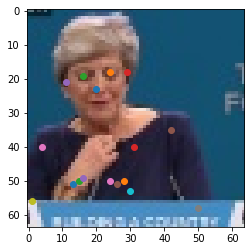

In [10]:
display_keypoints('person_0053/video_0230/seq_0000/frame_00001.jpg')

In [11]:
path_to_keypoints_scores

{'person_0000/video_0000/seq_0000/frame_00001.jpg': {'keypoints': array([[0.53459672, 0.12850846],
         [0.6406673 , 0.1446631 ],
         [0.52476055, 0.10412741],
         [0.4977904 , 0.13649018],
         [0.47562269, 0.11546797],
         [0.33334974, 0.25277446],
         [0.45026752, 0.26880702],
         [0.42770522, 0.42490223],
         [0.53967602, 0.44173826],
         [0.60782031, 0.492389  ],
         [0.64461068, 0.47813845],
         [0.31952851, 0.61815289],
         [0.40609561, 0.63205951],
         [0.37395964, 0.8852304 ],
         [0.39167636, 0.90134253],
         [0.36190295, 0.95790114],
         [0.36623314, 0.9836186 ]]),
  'scores': array([-0.16949274, -0.46518552,  0.20328417, -1.006828  ,  1.917044  ,
          1.180885  ,  1.4024657 , -0.49611926,  1.3232089 ,  0.46317533,
          1.3964068 ,  1.3003438 ,  1.3156751 ,  0.8199758 ,  0.9037734 ,
         -1.8879727 , -1.9926813 ], dtype=float32),
  'signature': array([0.03925453, 0.        , 0.8170339

In [47]:
def get_dists(keypoints):
    return [x for x in np.array([np.sqrt(sum((keypoint_1- keypoint_2)**2,0))  for keypoint_1 in keypoints for keypoint_2 in keypoints]) if x != 0]

In [49]:
for path in path_to_keypoints_scores:
    keypoints = path_to_keypoints_scores[path]['keypoints']
    dists = get_dists(keypoints)
    path_to_keypoints_scores[path]['dists'] = dists

In [23]:
keypoints.shape

(17, 2)

In [13]:
np.dot(np.array([1,2]) , np.array([2,3]))

8

In [14]:
import itertools

In [19]:
keypoints.shape

(581685, 17, 2)

In [46]:
[x for x in np.array([np.sqrt(sum((keypoint_1- keypoint_2)**2,0))  for keypoint_1 in keypoints for keypoint_2 in keypoints]) if x != 0]

(272,)